In [234]:
from pathlib import Path
import re
import numpy as np
import os
import cv2
from tqdm import tqdm
from FisheyeCalibrate import FisheyeCalibrator
from OmnidirCalibrate import OmnidirCalibrator
from DepthEstimation import DepthEstimator
from matplotlib import pyplot as plt

In [235]:
def rgb2rggb(rgb):
    R = rgb[::2, ::2, 0:1]
    Gr = rgb[::2, 1::2, 1:2]
    Gb = rgb[1::2, ::2, 1:2]
    B = rgb[1::2, 1::2, 2:]
    rggb = np.concatenate((R, Gr, Gb, B), axis=2)
    return rggb


def rggb2bayer(x):
    h, w = x.shape[:2]
    return x.reshape(h, w, 2, 2).transpose(0, 2, 1, 3).reshape(2*h, 2*w)


def bayer2rggb(x):
    h, w = x.shape[:2]
    return x.reshape(h//2, 2, w//2, 2).transpose(0, 2, 1, 3).reshape(h//2, w//2, 4)


def rggb2rgb(rggb):
    return cv2.cvtColor(np.uint16(rggb2bayer(rggb)*65535), cv2.COLOR_BAYER_BG2RGB)/65535.0

def decode_raw(img_path):
    raw = np.fromfile(img_path,dtype=np.uint16)
    h, w = 1080, 1352
    raw = raw[:h*w].reshape(h,w)

    raw = np.left_shift(raw, 6).astype(np.float32)/ 64.
    rggb = bayer2rggb(raw)
    rggb = (rggb / 1023).clip(0,1)
    # rgb = rggb2rgb(rggb)
    # cv2.imwrite('/data/temp/tmp.png',(rgb*255)[...,::-1].astype(np.uint8))
    return rggb
def _create_object_point(_board, _square_size):
    # _ -> object points grid refered board
    object_point = np.zeros((1, _board[0]*_board[1], 3), np.float32)
    object_point[0,:,:2] = np.mgrid[0:_board[0], 0:_board[1]].T.reshape(-1, 2)
    object_point = object_point*_square_size 
    return object_point

In [250]:
datadir = Path('/data/endo_data/3D_endo/0326-采图/rgb')
# print(_create_object_point((8,11),0.0052))
# exit()
# datadir = Path('/data/endo_data/3D_endo/0315-采图-1352-1080/rgb')
# datadir = Path('/data/endo_data/3D_endo/0318-采图/rgb')
lefts, rights, images = [], [], []
img_dic = {}
shape = None
right_imgpoints, left_imgpoints, object_points = [], [], []
n = 0
for left_path in tqdm(sorted(list(datadir.glob('left/*.jpg'))+list(datadir.glob('left/*.png')))):
    n += 1
    id = left_path.stem

    right_path = datadir /f'right/{left_path.name}'

    left_rgb = cv2.imread(left_path.as_posix())/255.
    right_rgb = cv2.imread(right_path.as_posix())/255.
    lefts.append((left_rgb*255).astype(np.uint8))
    rights.append((right_rgb*255).astype(np.uint8))
    right_image = cv2.cvtColor((right_rgb*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    left_image = cv2.cvtColor((left_rgb*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    

    flag = cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE
    right_ret, right_corner = cv2.findChessboardCorners(right_image, (8,11), flag)
    left_ret, left_corner = cv2.findChessboardCorners(left_image, (8,11), flag)

    shape = left_rgb.shape[:2]
    gray = (np.concatenate([left_rgb, right_rgb], axis=1)*255).astype(np.uint8)
    gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    # print(left_ret, right_ret)
    if not left_ret  or not right_ret:
        continue
    subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    right_corner =cv2.cornerSubPix(right_image,right_corner,(3,3),(-1,-1),subpix_criteria)
    right_imgpoints.append(right_corner.reshape(1,-1,2))
    
    subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    cv2.cornerSubPix(left_image,left_corner,(3,3),(-1,-1),subpix_criteria)
    left_imgpoints.append(left_corner.reshape(1,-1,2))
    object_point=_create_object_point((8,11),0.0052)
    object_points.append(object_point)

    
    
    images.append(gray)
    
    left_chess = cv2.drawChessboardCorners((right_rgb*255).astype(np.uint8), (8,11), right_corner,left_ret)
    out_path= datadir/'chess'/'right'/ f'{id}.png'
    out_path.parent.mkdir(parents=True,exist_ok=True)
    cv2.imwrite(out_path.as_posix(), left_chess)
    right_chess = cv2.drawChessboardCorners((left_rgb*255).astype(np.uint8), (8,11), left_corner,right_ret)
    out_path= datadir/'chess'/'left'/ f'{id}.png'
    out_path.parent.mkdir(parents=True,exist_ok=True)
    cv2.imwrite(out_path.as_posix(), right_chess)
    

    img_dic[id]={
        'left': (left_rgb*255).astype(np.uint8),
        'right': (right_rgb*255).astype(np.uint8),
        'object_point': object_point,
        'left_corner': left_corner.reshape(1,-1,2),
        'right_corner': right_corner.reshape(1,-1,2)
    }



100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


In [251]:

omnidirCalibrator = OmnidirCalibrator(img_dic=img_dic,image_size=left_chess.shape[:2])
omnidirCalibrator.stereo_calibrate()
o = omnidirCalibrator

obp = _create_object_point((8,11),0.0052)
lps, op_j = cv2.omnidir.projectPoints(objectPoints=obp,rvec=o.rvecsL[0],tvec=o.tvecsL[0],K=o._left_K,xi=o._left_xi[0].astype(np.double)[0],D=o._left_D)


stereo calibrating ...
cv2.omnidir.calibrate: left:1.1371822144489399
[[2 8 9]]
cv2.omnidir.calibrate: right:1.2433306481438322
[[ 0  1  2  3  4  5  6  7  8  9 12 13 14 21 22 24 25 26 27 28 29 30 31 32
  33 35 36 37]]
[[ 2381.566  0.000  762.483]
 [ 0.000  2382.867  744.015]
 [ 0.000  0.000  1.000]]
[[ 5.069 -23.313 -0.006 -0.006]]
[[ 2271.027  0.000  794.725]
 [ 0.000  2271.043  731.333]
 [ 0.000  0.000  1.000]]
[[ 5.144 -19.890 -0.004  0.001]]
[[ 2.211]] [[ 2.212]]
42 42 42
cv2.omnidir.stereoCalibrate: 0.6073193688063036
[[2 8 9]]
[[ 1747.693  0.000  762.145]
 [ 0.000  1748.757  743.188]
 [ 0.000  0.000  1.000]]
[[ 2.824 -7.596 -0.005 -0.004]]
[[ 2859.020  0.000  794.880]
 [ 0.000  2859.944  731.811]
 [ 0.000  0.000  1.000]]
[[ 9.356 -37.531 -0.006  0.001]]
[[ 1.538]] [[ 3.152]]
[[-0.046]
 [ 0.171]
 [ 0.036]]
[[-0.003]
 [ 0.000]
 [ 0.000]]
stereo calibration was successful.


0.5366025395873194


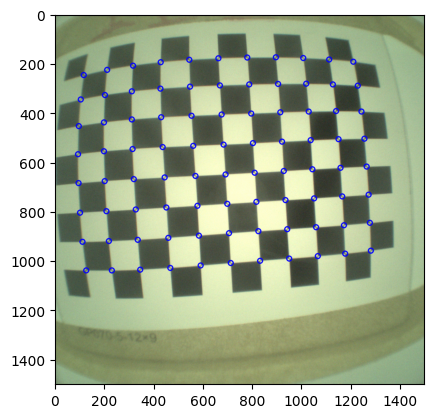

In [253]:
img = img_dic['0009']['left'].copy()
for point in lps[0]:
    cv2.circle(img,(int(point[0]),int(point[1])),10,(0,0,255),4)
# print(img_dic['0002']['left_corner'][0])
# for point in img_dic['0008']['left_corner'][0]:
#     cv2.circle(img,(int(point[0]),int(point[1])),10,(255,0,0),4)
errors = []
for point_rpro, point_chess in zip(lps[0],img_dic['0009']['left_corner'][0]):
    err = np.sqrt((point_rpro[0]-point_chess[0])**2 + (point_rpro[1]-point_chess[1])**2)
    errors.append(err)
print(np.mean(errors))
plt.imshow(img)

8x8x8
[[-0.121  0.993 -0.003 -0.055]
 [-0.990 -0.121  0.067  0.021]
 [ 0.067  0.011  0.998  0.042]
 [ 0.000  0.000  0.000  1.000]]
0.1614104860131542


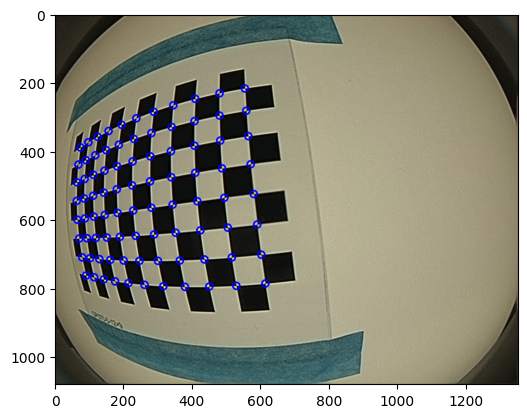

In [156]:
r_L2o,_ = cv2.Rodrigues(o.rvecsL[0])

RT_L2O = np.zeros((4,4))
RT_L2O[:3,:3]= r_L2o
RT_L2O[:3,-1] = o.tvecsL[0].reshape(3)
RT_L2O[-1,-1]=1
RT_L2R = np.eye(4)
R_L2R, _ = cv2.Rodrigues(o._R)

print('8x8x8')
RT_L2R[:3,:3] = R_L2R
RT_L2R[:3,-1] = o._T.reshape(3)
# RT_R2O = np.matmul(RT_L2O,RT_L2R)
# print(RT_R2O)
RT_R2O = np.matmul(RT_L2R,RT_L2O)
print(RT_R2O)
r_R2O, _ = cv2.Rodrigues(RT_R2O[:3,:3])
t_R2O = RT_R2O[:3,-1].reshape(1,3)
rps, op_j = cv2.omnidir.projectPoints(objectPoints=obp,rvec=r_R2O,tvec=t_R2O,K=o._right_K,xi=o._right_xi[0].astype(np.double)[0],D=o._right_D)
img = img_dic['0002']['right'].copy()

for point in rps[0]:
    cv2.circle(img,(int(point[0]),int(point[1])),10,(0,0,255),4)
errors = []
for point_rpro, point_chess in zip(rps[0],img_dic['0002']['right_corner'][0]):
    err = np.sqrt((point_rpro[0]-point_chess[0])**2 + (point_rpro[1]-point_chess[1])**2)
    errors.append(err)
print(np.mean(errors))
plt.clf()
plt.imshow(img)

[[-0.000]
 [ 0.002]
 [-0.050]] [[-0.024]
 [-0.000]
 [-0.035]] [[ 0.024]
 [ 0.003]
 [-0.014]]
47.18408
4.008296e-08


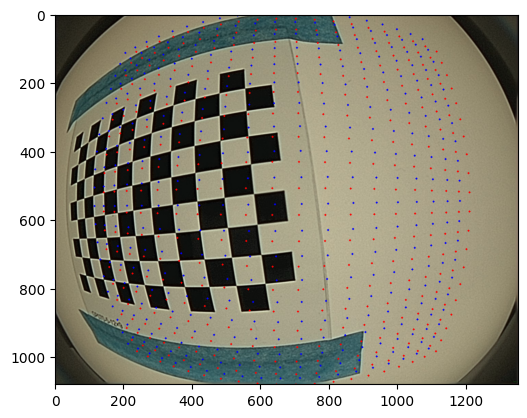

In [232]:
R1, R2 = cv2.omnidir.stereoRectify(o._R, o._T)
# print(R1,R2,o._R)
v_r1,_ = cv2.Rodrigues(R1)
v_r2, _ = cv2.Rodrigues(R2)
print(v_r1, v_r2, o._R)
obp = _create_object_point((20,20),0.0052)
obp[:,:,-1]=0.05
obp[:,:,0]-=0.05
obp[:,:,1]-=0.05
# print(obp)
r_L2O, _ = cv2.Rodrigues(np.eye(3))
# r_R2O, _ = cv2.Rodrigues(R2)
t_L2O = np.zeros((1,3))
t_R2O = o._T.reshape(1,3)

lps, op_j = cv2.omnidir.projectPoints(objectPoints=obp,rvec=r_L2O,tvec=t_L2O,K=o._left_K,xi=o._left_xi[0].astype(np.double)[0],D=o._left_D)
rps, op_j = cv2.omnidir.projectPoints(objectPoints=obp,rvec=o._R,tvec=t_R2O,K=o._right_K,xi=o._right_xi[0].astype(np.double)[0],D=o._right_D)
img = img_dic['0002']['right'].copy()
# print(rps)
for point in rps[0]:
    cv2.circle(img,(int(point[0]),int(point[1])),1,(0,0,255),3)
for point in lps[0]:
    cv2.circle(img,(int(point[0]),int(point[1])),1,(255,0,0),3)
y_error = []
for p1, p2 in zip(lps[0], rps[0]):
    # print(p1,p2)
    y_error.append(np.abs(p1[0]-p2[0]))
print(np.mean(y_error))
plt.imshow(img)
# 

e_l = cv2.omnidir.undistortPoints(distorted=lps,K=o._left_K,D=o._left_D,xi=o._left_xi,R=R1)
e_r = cv2.omnidir.undistortPoints(distorted=rps,K=o._right_K,D=o._right_D,xi=o._right_xi,R=R2)
# print(e_l[0])
y_error = []

for p1, p2 in zip(e_l[0], e_r[0]):
    # print(p1,p2)
    y_error.append(np.abs(p1[1]-p2[1]))
print(np.mean(y_error))
# plt.imshow(img)
img = img_dic['0002']['right'].copy()
# print(rps)
for point in e_l[0]:
    cv2.circle(img,(int(point[0]),int(point[1])),1,(0,0,255),3)
for point in e_r[0]:
    cv2.circle(img,(int(point[0]),int(point[1])),1,(255,0,0),3)
# plt.imshow(img)

3.0062219593673944e-05


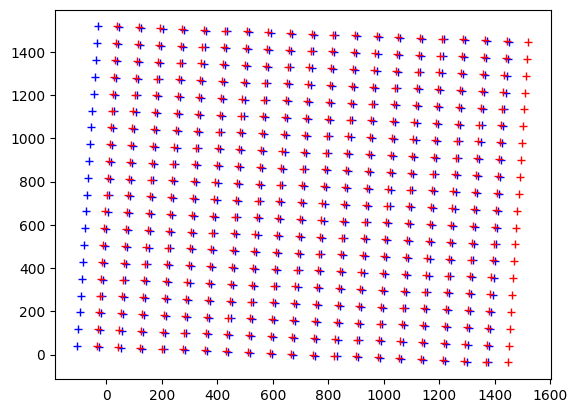

In [233]:
knew = np.array([[750,0,750],[0,750,750],[0,0,1]])
v = e_l.copy()[0]
v = np.concatenate([v, np.ones((v.shape[0],1))],axis=1)
uv_l= np.matmul(knew,v.T).T

v = e_r.copy()[0]
v = np.concatenate([v, np.ones((v.shape[0],1))],axis=1)
uv_r = np.matmul(knew,v.T).T

y_error = []
for p_l, p_r in zip(uv_l,uv_r):
    # print(p_l, p_r)
    y_error.append(np.abs(p_l[1]-p_r[1]))
print(np.mean(y_error))
# print(y_error)
plt.plot(uv_r[:,0],uv_r[:,1],'b+')
plt.plot(uv_l[:,0],uv_l[:,1],'r+')